In [1]:
from PIL import Image
import os
from glob import glob
from matplotlib import pyplot as plt
import cv2
import numpy as np

## Get all of the images in the same size so they can all be processed and given the same metrics and get the same effect

In [2]:
def standardize_image(image, target_height=600, target_width=900):
    # Get current dimensions
    height, width = image.shape[:2]
    
    # Calculate scaling factors for both dimensions
    height_scale = target_height / height
    width_scale = target_width / width
    
    # Use the smaller scaling factor to maintain aspect ratio
    scale = min(height_scale, width_scale)
    
    # Calculate new dimensions
    new_height = int(height * scale)
    new_width = int(width * scale)
    
    # Resize image
    standardized = cv2.resize(image, (new_width, new_height))
    
    # Create a black canvas of target size
    final_image = np.zeros((target_height, target_width, 3), dtype=np.uint8)
    
    # Calculate positioning to center the image
    y_offset = (target_height - new_height) // 2
    x_offset = (target_width - new_width) // 2
    
    # Place the resized image in the center of the canvas
    final_image[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = standardized
    
    return final_image

## Preprocess the image
- Convert to LAB colour space to try get white colour to pop out more
- Apply CLAHE to try get teh colour enhancement and colour changes to stand out more
- gets colour difference by getting the median colour difference and seeing how much pixels vary from this to try get the white lines to stand out more.

In [3]:
def preprocess_image(img):
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original image
    axes[0][0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0][0].set_title('Original Image')
    axes[0][0].axis('off')
    
    # Convert to LAB and show L channel
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    axes[0][1].imshow(l, cmap='gray')
    axes[0][1].set_title('L Channel')
    axes[0][1].axis('off')
    
    # Apply CLAHE and show enhanced L channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced_l = clahe.apply(l)
    axes[0][2].imshow(enhanced_l, cmap='gray')
    axes[0][2].set_title('Enhanced L Channel (CLAHE)')
    axes[0][2].axis('off')
    
    # Show a and b channels
    axes[1][0].imshow(a, cmap='gray')
    axes[1][0].set_title('a Channel (Green-Red)')
    axes[1][0].axis('off')
    
    axes[1][1].imshow(b, cmap='gray')
    axes[1][1].set_title('b Channel (Blue-Yellow)')
    axes[1][1].axis('off')
    
    # Calculate and show color difference
    enhanced_lab = cv2.merge([enhanced_l, a, b])
    median_color = np.median(enhanced_lab.reshape(-1, 3), axis=0)
    amplification_factor = 5
    diff_channels = (enhanced_lab - median_color)*amplification_factor
    color_diff = np.sqrt(np.sum(diff_channels**2, axis=2))
    color_diff = cv2.normalize(color_diff, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    axes[1][2].imshow(color_diff, cmap='gray')
    axes[1][2].set_title('Final Color Difference')
    axes[1][2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return color_diff

## Get parking lines and cars and try to isolate parking lines.
- reads image in and erodes parking lines away so you only have the cars and noise.
- dilates cars and noise so they are around biig enough to resemble the cars in the original binary image.
- xors with original binary image to try get rid of cars and noise and only be left with car lines.

In [480]:
def detect_white_lines(img):
    # Convert to HSV for better white line detection
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Define range for white color in HSV
    lower_white = np.array([0, 0, 180])#190
    upper_white = np.array([180, 30, 255])
    
    # Create mask for white colors
    white_mask = cv2.inRange(hsv, lower_white, upper_white)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    axes[0][0].imshow(white_mask, cmap='gray')
    axes[0][0].set_title('Original White Mask')
    axes[0][0].axis('off')
    
    # First create larger blobs to capture cars
    kernel_car = cv2.getStructuringElement(cv2.MORPH_RECT, (9,13))
    car_blobs = cv2.morphologyEx(white_mask, cv2.MORPH_OPEN, kernel_car, iterations=3)
    
    axes[0][1].imshow(car_blobs, cmap='gray')
    axes[0][1].set_title('Dilated Blobs')
    axes[0][1].axis('off')
    
    # Then erode to create gaps between lines and cars
    kernel_car = cv2.getStructuringElement(cv2.MORPH_RECT, (9,13))
    #kernel_car = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
    car_blobs = cv2.morphologyEx(car_blobs, cv2.MORPH_DILATE, kernel_car, iterations=4)
    #car_blobs = cv2.morphologyEx(car_blobs, cv2.MORPH_DILATE, kernel_car, iterations=1)
    
    axes[0][2].imshow(car_blobs, cmap='gray')
    axes[0][2].set_title('Eroded Blobs')
    axes[0][2].axis('off')
    
    # AND between original and inverted car blobs to keep only lines
    car_mask = cv2.bitwise_not(car_blobs)
    just_lines = cv2.bitwise_and(white_mask, car_mask)
    
    axes[1][0].imshow(car_mask, cmap='gray')
    axes[1][0].set_title('Car Mask (Inverted)')
    axes[1][0].axis('off')
    
    # Clean up the lines
    kernel_line = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    cleaned_lines = cv2.morphologyEx(just_lines, cv2.MORPH_CLOSE, kernel_line, iterations=20)
    
    
    axes[1][1].imshow(just_lines, cmap='gray')
    axes[1][1].set_title('Lines Only')
    axes[1][1].axis('off')
    
    axes[1][2].imshow(cleaned_lines, cmap='gray')
    axes[1][2].set_title('Cleaned Lines')
    axes[1][2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return just_lines

## Once we have parking lines isolated try to improve their visibility so cropping can take place. 
- Firstly blur the image to try minimise nosie.
- Carry out edge detection to impose teh parking lines and get rid of nosie that isn't a majopor edge. 
- Carry out hough transform to try and build lines and join themm together 
- Do dilation and erosion to make the lines stand out a little more before cropping. 
- I think detected parking spaces image doesn't do much for the image here

In [5]:
def detect_parking_lines(img):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Convert to grayscale if not already
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
        
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)
    
    axes[0][0].imshow(edges, cmap='gray')
    axes[0][0].set_title('Edge Detection')
    axes[0][0].axis('off')
    
    # Use probabilistic Hough transform to detect lines
    lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi/180,
        threshold=40,#40
        minLineLength=50,  # Minimum length of line
        maxLineGap=50 #50      # Maximum gap between line segments
    )
    
    # Create separate images for horizontal and vertical lines
    horizontal_lines = np.zeros_like(gray)
    vertical_lines = np.zeros_like(gray)
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            
            # Calculate line angle
            angle = np.abs(np.arctan2(y2 - y1, x2 - x1) * 180.0 / np.pi)
            
            # Calculate line length
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            
            # Classify lines based on angle
            if (angle < 20) or (angle > 160):  # Horizontal lines
                if length > 50:  # Filter by minimum length
                    cv2.line(horizontal_lines, (x1, y1), (x2, y2), 255, 2)
            elif (70 < angle < 110):  # Vertical lines
                if length > 50:  # Filter by minimum length
                    cv2.line(vertical_lines, (x1, y1), (x2, y2), 255, 2)
    
    axes[0][1].imshow(horizontal_lines, cmap='gray')
    axes[0][1].set_title('Horizontal Lines')
    axes[0][1].axis('off')
    
    axes[0][2].imshow(vertical_lines, cmap='gray')
    axes[0][2].set_title('Vertical Lines')
    axes[0][2].axis('off')
    
    # Combine horizontal and vertical lines
    combined_lines = cv2.bitwise_or(horizontal_lines, vertical_lines)
    
    # Clean up the lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    cleaned_lines = cv2.morphologyEx(combined_lines, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    axes[1][0].imshow(cleaned_lines, cmap='gray')
    axes[1][0].set_title('Combined Lines')
    axes[1][0].axis('off')
    
    # Find contours to identify parking spaces
    contours, _ = cv2.findContours(cleaned_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours by area and aspect ratio
    parking_spaces = np.zeros_like(gray)
    min_area = 1000
    
    if contours:
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > min_area:
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = float(w)/h
                # Check if the aspect ratio is reasonable for a parking space
                if 0.2 < aspect_ratio < 5:
                    cv2.drawContours(parking_spaces, [contour], -1, 255, 2)
    
    axes[1][1].imshow(parking_spaces, cmap='gray')
    axes[1][1].set_title('Detected Parking Spaces')
    axes[1][1].axis('off')
    
    # Hide unused subplot
    axes[1][2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return cleaned_lines

In [124]:
def get_birds_eye_view(image):
    """
    Apply perspective transform to cropped parking area with adjusted points
    """
    height, width = image.shape[:2]
    
    # Adjusted source points for your specific image
    src_points = np.float32([
        [0, height-10],       # Bottom left (slight adjustment for misalignment)
        [width-1, height], # Bottom right (slight adjustment for misalignment)
        [width * 0.90, 5],    # Top right (adjusted for stronger perspective on right)
        [0+5, 5]     # Top left (adjusted for your image)
    ])
    
    # Destination points - making a perfect rectangle
    dst_points = np.float32([
        [0, height-1],        # Bottom left
        [width-1, height-1],  # Bottom right
        [width-1, -30],         # Top right
        [0, 0]                # Top left
    ])
    
    # Calculate and apply transform
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    warped = cv2.warpPerspective(image, matrix, (width, height))
    
    return warped

## Crop image to only detect parking spaces
Try crop the parking regions out based on the vertiical and horizontal lines that have been created in the previous method so we are only left with parking spaces and cars it should be alot easier to then see the occupancy of parkking spaces. 

In [24]:
def crop_parking_regions(parking_area, original_img):
    height, width = parking_area.shape[:2]
    padding_y = 0
    padding_x = 20
    
    # Get projections
    horizontal_projections = np.sum(parking_area, axis=1)
    vertical_projections = np.sum(parking_area, axis=0)
    
    # Normalize projections
    horizontal_projections = horizontal_projections / width
    vertical_projections = vertical_projections / height
    
    # Find significant horizontal lines
    horizontal_lines = np.where(horizontal_projections > 0.15)[0]
    vertical_lines = np.where(vertical_projections > 0.15)[0]
    
    # Group horizontal lines by proximity
    grouped_lines = []
    current_group = [horizontal_lines[0]]
    
    for i in range(1, len(horizontal_lines)):
        if horizontal_lines[i] - horizontal_lines[i-1] < 20:
            current_group.append(horizontal_lines[i])
        else:
            grouped_lines.append(current_group)
            current_group = [horizontal_lines[i]]
    grouped_lines.append(current_group)
    
    # Create regions from groups
    crop_coordinates = []  # Store the coordinates for cropping
    min_region_height = height * 0.15
    
    # Find x boundaries using vertical lines - do this once for all crops
    x_start = max(0, vertical_lines[0] - padding_x)
    x_end = min(width, vertical_lines[-1] + padding_x)
    
    for i, group in enumerate(grouped_lines):
        if i == 0 or i == len(grouped_lines) - 1:  # Top or bottom region
            start = max(0, min(group) - padding_y)
            end = min(height, max(group) + padding_y)
            if end - start > min_region_height:
                crop_coordinates.append((start, end, x_start, x_end))
        else:  # Middle groups - check height to filter out arrows
            start = max(0, min(group) - padding_y)
            end = min(height, max(group) + padding_y)
            if end - start > height * 0.2:
                crop_coordinates.append((start, end, x_start, x_end))
    
    # Create figure with enough subplots for both binary and original crops
    num_regions = len(crop_coordinates)
    fig = plt.figure(figsize=(15, 5 * num_regions))
    
    binary_crops = []
    original_crops = []
    
    for i, (y_start, y_end, x_start, x_end) in enumerate(crop_coordinates):
        # Create crops using the same coordinates for both
        binary_crop = parking_area[y_start:y_end, x_start:x_end]
        original_crop = original_img[y_start:y_end, x_start:x_end].copy()  # Make a copy to avoid reference issues
        
        binary_crops.append(binary_crop)
        original_crops.append(original_crop)
        
        # Create side-by-side plots
        # Binary crop (left side)
        ax1 = fig.add_subplot(num_regions, 2, 2*i + 1)
        ax1.imshow(binary_crop, cmap='gray')
        ax1.set_title(f'Region {i+1} - Binary\nSize: {binary_crop.shape}')
        ax1.axis('off')
        
        # Original crop (right side)
        ax2 = fig.add_subplot(num_regions, 2, 2*i + 2)
        ax2.imshow(cv2.cvtColor(original_crop, cv2.COLOR_BGR2RGB))
        ax2.set_title(f'Region {i+1} - Original\nSize: {original_crop.shape}')
        ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
        
    return binary_crops, original_crops, crop_coordinates

## Draw boxes around firstly the full parking spaces and then each indicviusal parking space and then we should be ready to see if the space is full or empty

In [476]:
def detect_parking_spaces(binary_crop, original_crop):
    height, width = binary_crop.shape[:2]
    
    # Calculate projections and normalize
    vertical_proj = np.sum(binary_crop, axis=0)
    horizontal_proj = np.sum(binary_crop, axis=1)
    vertical_proj = vertical_proj / np.max(vertical_proj)
    
    # Keep existing vertical peak detection
    window_size = 15
    v_peaks = []
    for i in range(window_size, len(vertical_proj) - window_size):
        window = vertical_proj[i-window_size:i+window_size]
        if (vertical_proj[i] >= max(window) and 
            vertical_proj[i] > 0.3 and
            (not v_peaks or i - v_peaks[-1] >= 60)):
            v_peaks.append(i)
    
    # Add edge peaks if they're close to expected spacing
    if len(v_peaks) > 1:
        avg_spacing = np.mean([v_peaks[i+1] - v_peaks[i] for i in range(len(v_peaks)-1)])
        
        if v_peaks[0] > avg_spacing * 0.8:
            v_peaks.insert(0, 0)
        if (width - v_peaks[-1]) > avg_spacing * 0.8:
            v_peaks.append(width)
    
    # Modified horizontal peak detection to handle up to 3 peaks
    h_threshold = 100000
    h_peaks = []
    min_peak_distance = 20  # Minimum distance between peaks
    
    # Find potential peaks
    for i in range(1, len(horizontal_proj) - 1):
        if (horizontal_proj[i] > h_threshold and
            horizontal_proj[i] > horizontal_proj[i-1] and
            horizontal_proj[i] > horizontal_proj[i+1] and
            (not h_peaks or i - h_peaks[-1] >= min_peak_distance)):
            h_peaks.append(i)
    
    # Sort peaks by strength and keep up to 3 strongest
    h_peaks.sort(key=lambda x: horizontal_proj[x], reverse=True)
    h_peaks = h_peaks[:3]  # Keep only up to 3 strongest peaks
    h_peaks.sort()  # Sort back by position
    
    # Draw visualization
    result = original_crop.copy()
    
    # Draw red vertical and horizontal lines
    for x in v_peaks:
        cv2.line(result, (x, 0), (x, height), (0, 0, 255), 2)
    
    for y in h_peaks:
        cv2.line(result, (0, y), (width, y), (0, 0, 255), 2)
    
    # Process parking spots
    spot_number = 1
    min_spot_width = 20
    
    # Define sections based on horizontal peaks
    h_sections = []
    if not h_peaks:
        h_sections = [(0, height)]
    else:
        h_sections = [(0, h_peaks[0])]
        for i in range(len(h_peaks)-1):
            h_sections.append((h_peaks[i], h_peaks[i+1]))
        h_sections.append((h_peaks[-1], height))
    
    # Process parking spots in each section
    for section_start, section_end in h_sections:
        for i in range(len(v_peaks)-1):
            x1, x2 = v_peaks[i], v_peaks[i+1]
            spot_width = x2 - x1
            
            if spot_width < min_spot_width:
                continue
            
            spot_height = section_end - section_start
            aspect_ratio = spot_width / spot_height if spot_height > 0 else 0
            
            if 0.2 <= aspect_ratio <= 3.0:
                cv2.rectangle(result, (x1, section_start), (x2, section_end), (255, 165, 0), 2)
                cv2.putText(result, str(spot_number), 
                           ((x1 + x2)//2, (section_start + section_end)//2),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 165, 0), 2)
                spot_number += 1
    
    # Visualization remains the same
    fig, axes = plt.subplots(4, 1, figsize=(15, 16))
    
    axes[0].imshow(binary_crop, cmap='gray')
    axes[0].set_title('Binary Image')
    axes[0].axis('off')
    
    axes[1].plot(vertical_proj)
    axes[1].axhline(y=0.3, color='r', linestyle='--', label='Peak Threshold')
    axes[1].set_title('Vertical Projection')
    axes[1].legend()
    
    axes[2].plot(horizontal_proj)
    axes[2].axhline(y=h_threshold, color='r', linestyle='--', label='Threshold')
    axes[2].set_title('Horizontal Projection')
    axes[2].legend()
    
    axes[3].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    axes[3].set_title('Detected Parking Spaces')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return v_peaks, h_peaks, result

In [80]:
def extract_parking_spots(original_img, v_peaks, h_peaks):
    height, width = original_img.shape[:2]
    parking_spots = []
    
    # Define vertical sections between consecutive v_peaks
    for i in range(len(v_peaks)-1):
        x1 = v_peaks[i]
        x2 = v_peaks[i+1]
        
        if len(h_peaks) == 0:
            # If no horizontal peaks, treat as one section
            spot = {
                'coords': (x1, 0, x2, height),
                'roi': original_img[0:height, x1:x2]
            }
            parking_spots.append(spot)
        else:
            # Create sections between horizontal lines
            y_sections = [0] + h_peaks + [height]
            for j in range(len(y_sections)-1):
                y1 = y_sections[j]
                y2 = y_sections[j+1]
                
                # Add spot if it has reasonable dimensions
                if (x2 - x1) > 20 and (y2 - y1) > 20:
                    spot = {
                        'coords': (x1, y1, x2, y2),
                        'roi': original_img[y1:y2, x1:x2]
                    }
                    parking_spots.append(spot)
    
    return parking_spots

In [484]:
def analyze_parking_spot_occupancy(original_crop, spots):
    results = []
    vis_img = original_crop.copy()
    
    for spot in spots:
        x1, y1, x2, y2 = spot['coords']
        spot_roi = spot['roi']

        # Analyze the full parking space
        def analyze_full_space(roi):
            gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            edges = cv2.Canny(gray, 50, 150)
            variance = np.var(gray)
            edge_density = np.sum(edges > 0) / edges.size
            return variance > 1500 or edge_density > 0.10

        is_occupied = analyze_full_space(spot_roi)

        color = (0, 0, 255) if is_occupied else (0, 255, 0)
        cv2.rectangle(vis_img, (x1, y1), (x2, y2), color, 2)
        label = 'Occupied' if is_occupied else 'Vacant'
        cv2.putText(vis_img, label, (x1 + 5, y1 + 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        
        results.append({
            'coords': (x1, y1, x2, y2),
            'occupied': is_occupied
        })
    
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(original_crop, cv2.COLOR_BGR2RGB))
    plt.title('Original Crop')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.title('Occupancy Analysis')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return results, vis_img

# MAIN PROCESSING  LOOP

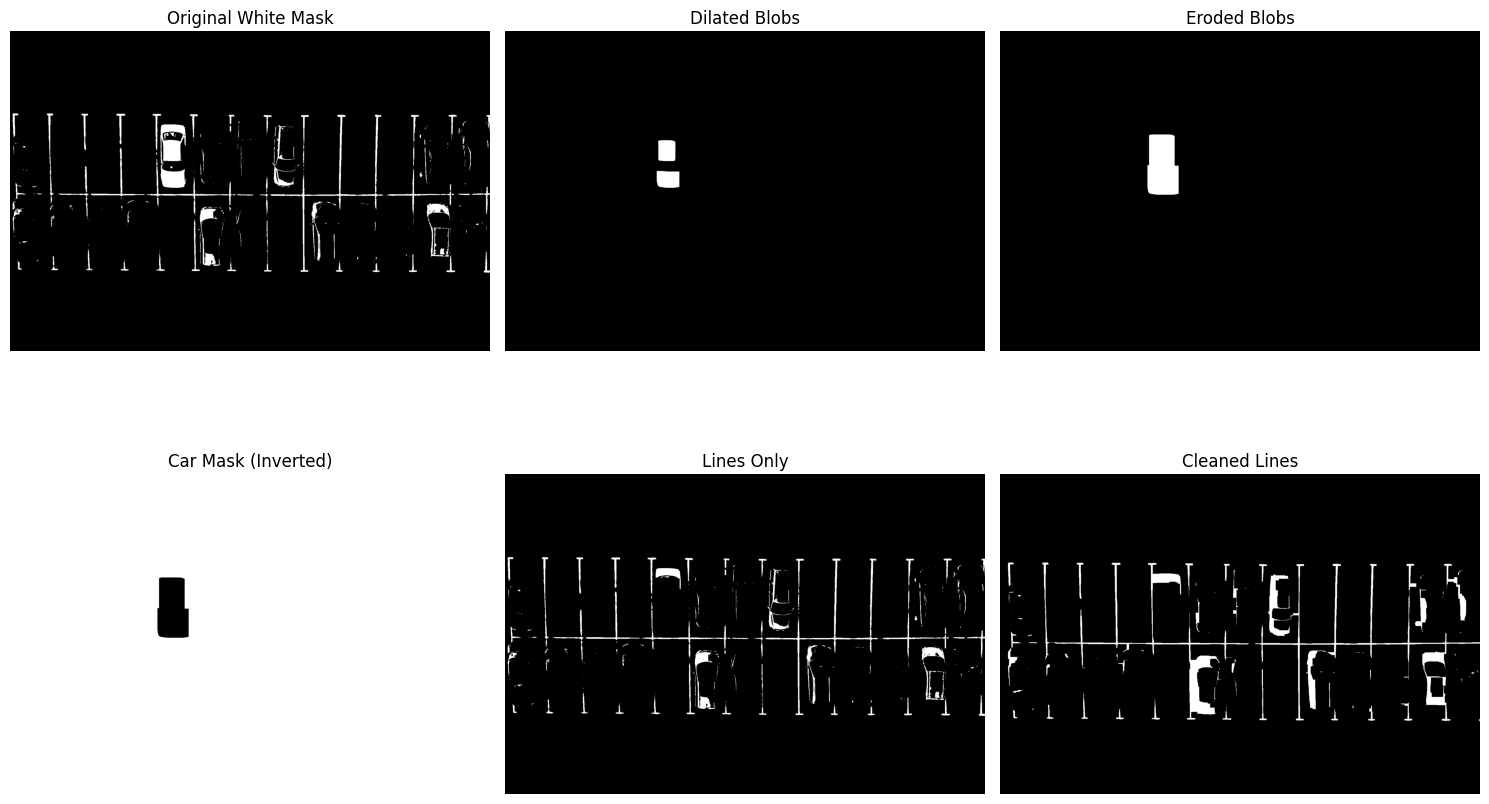

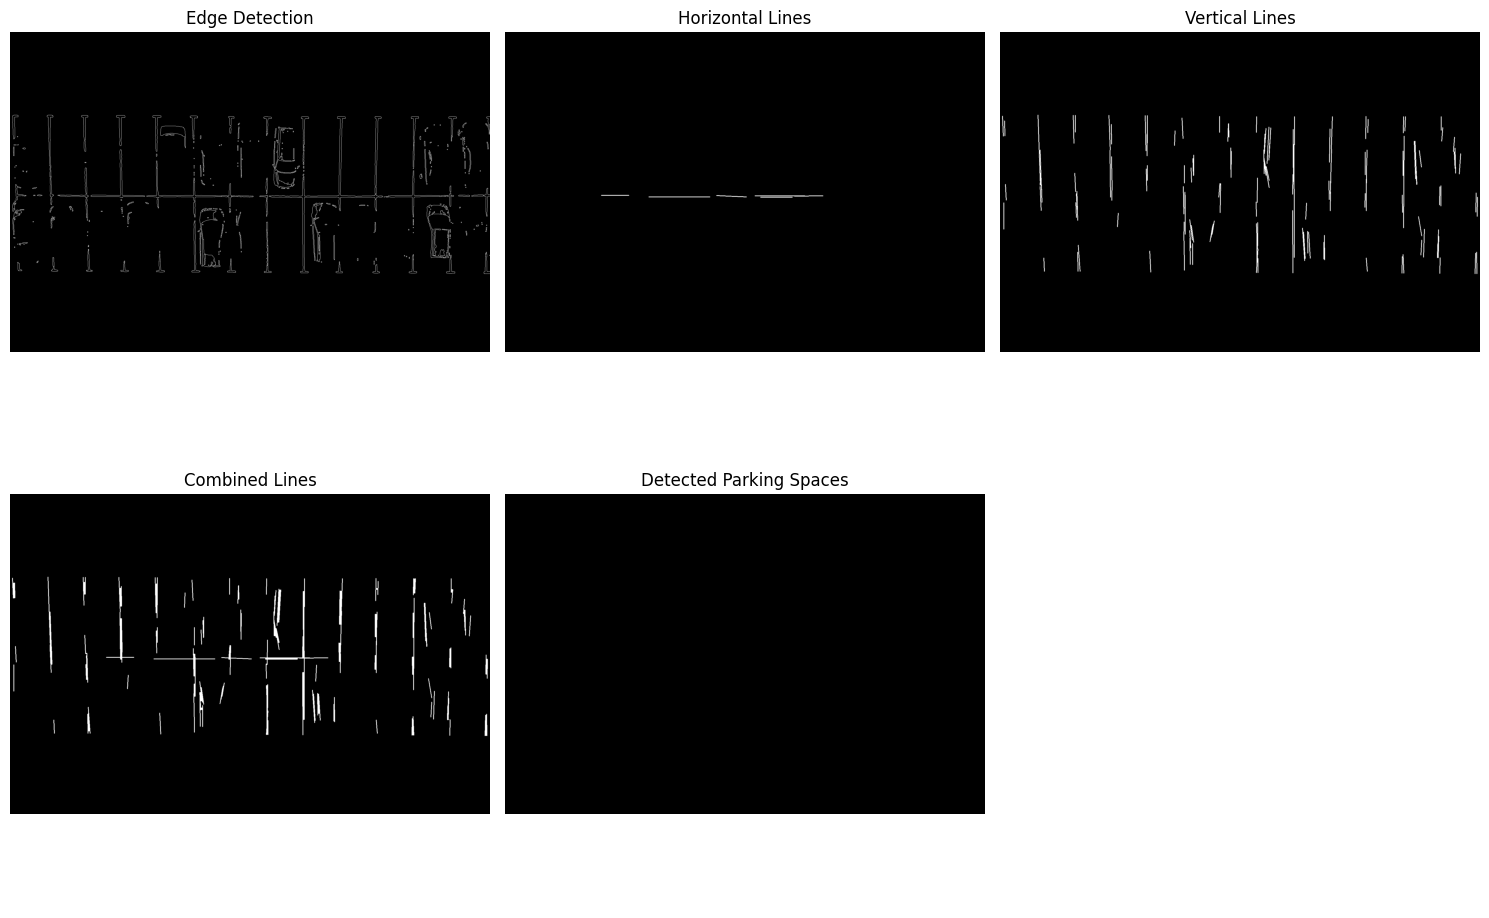

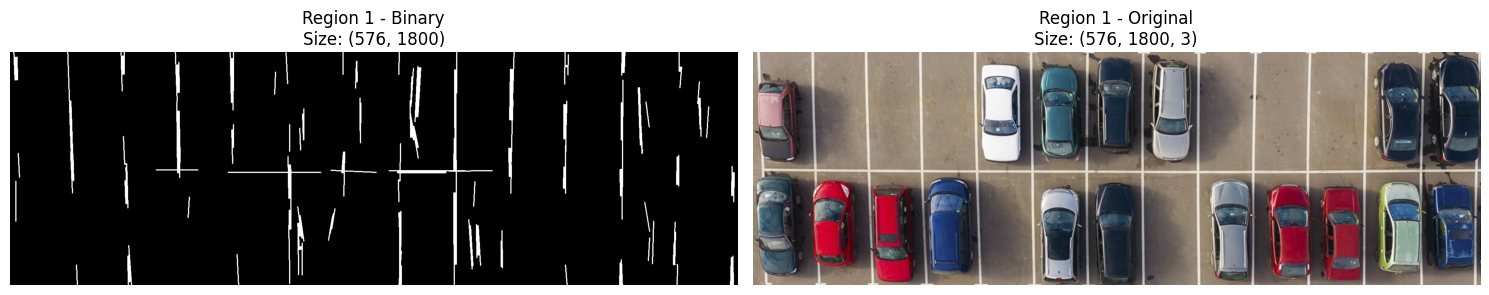

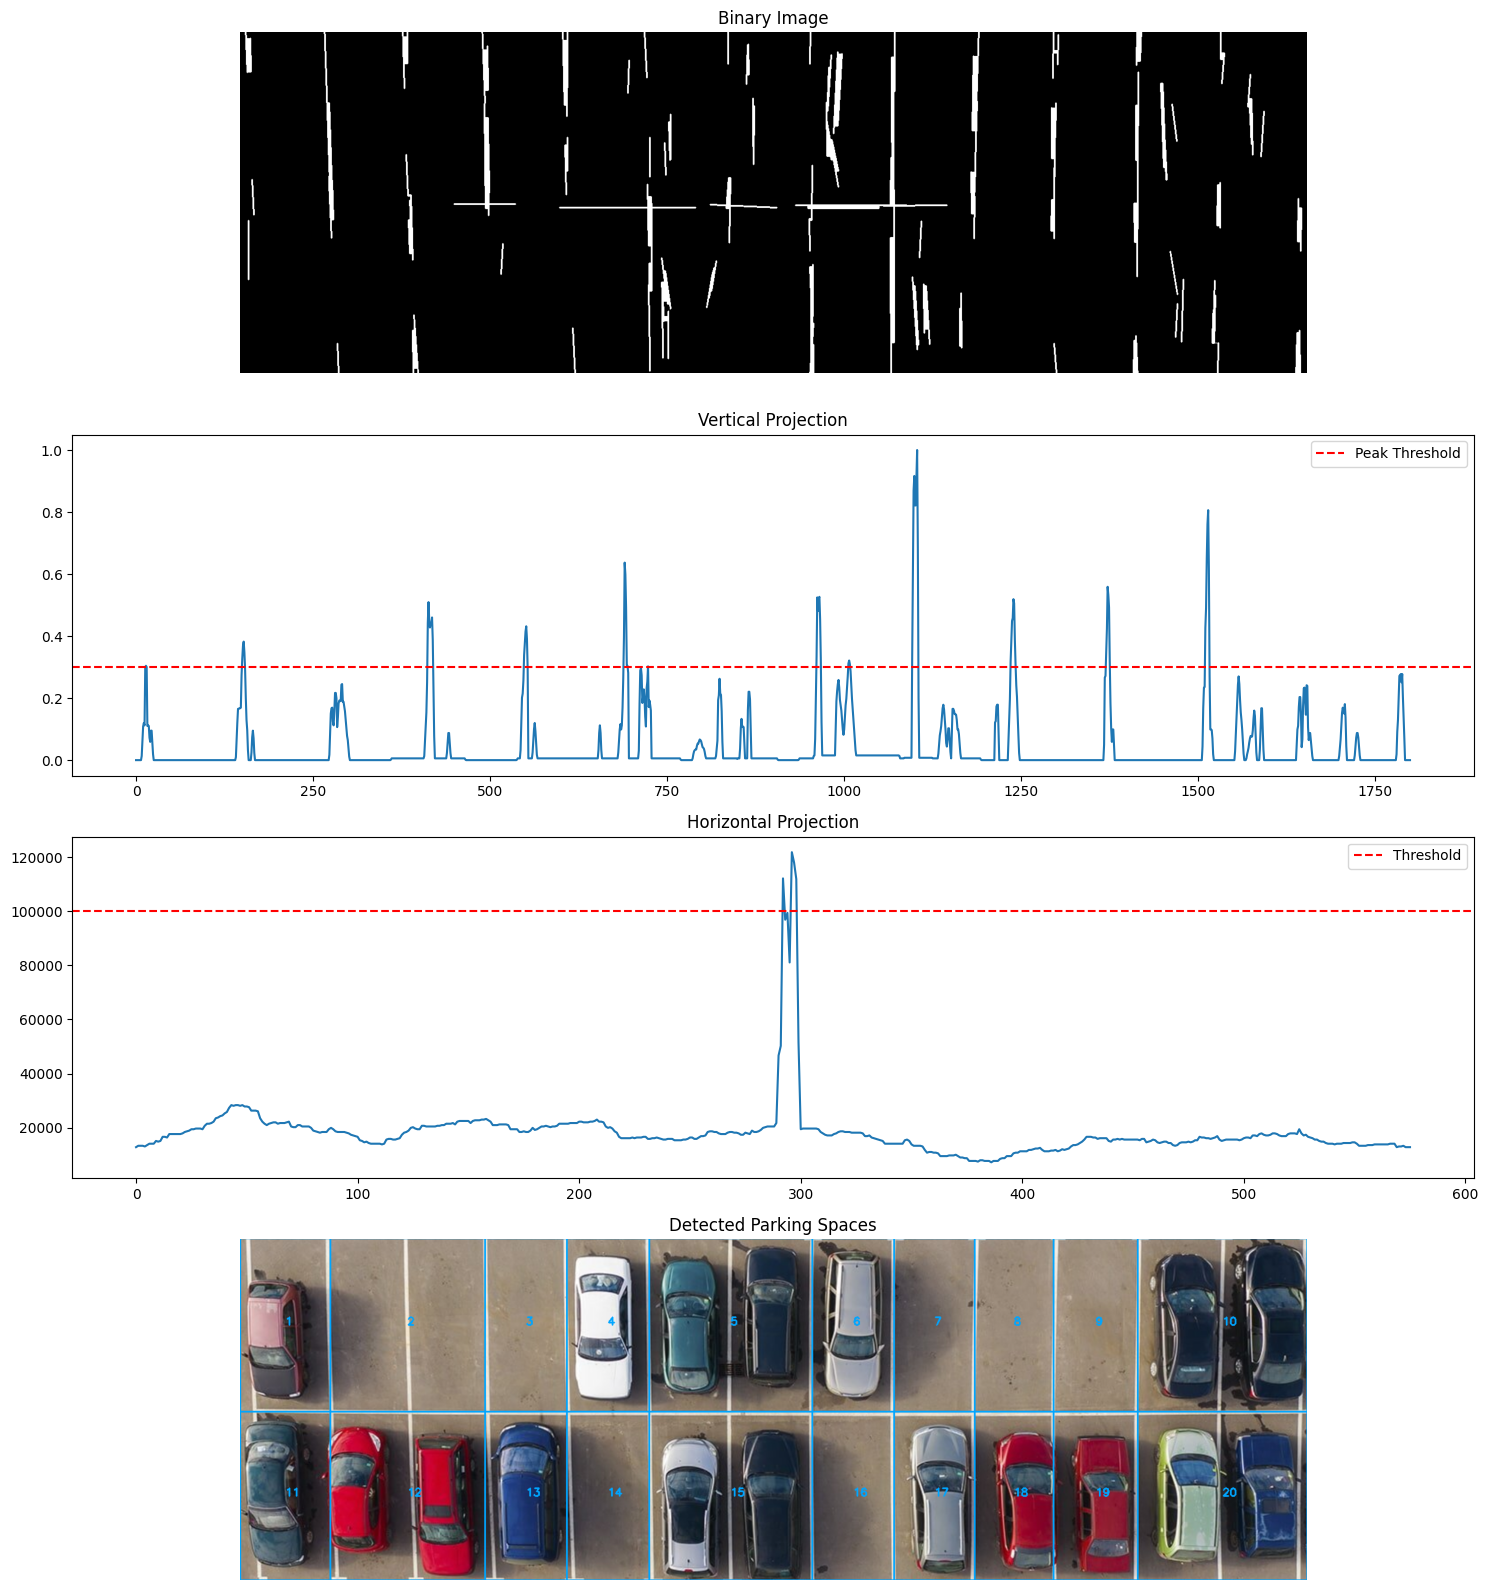

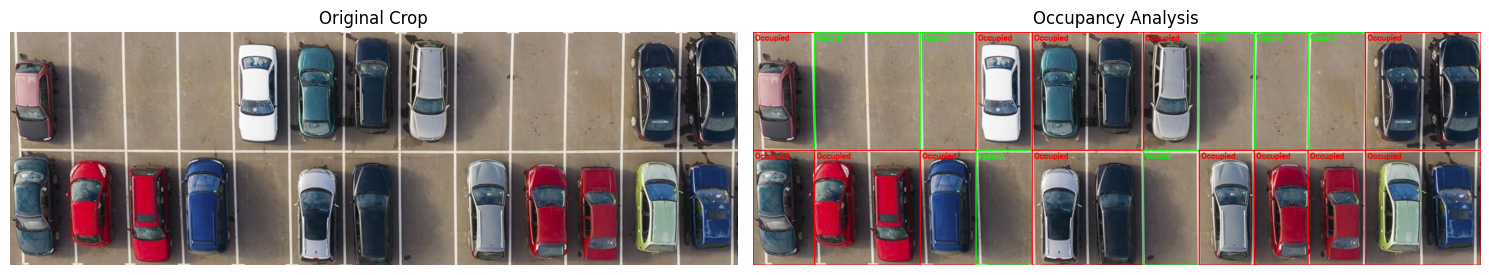

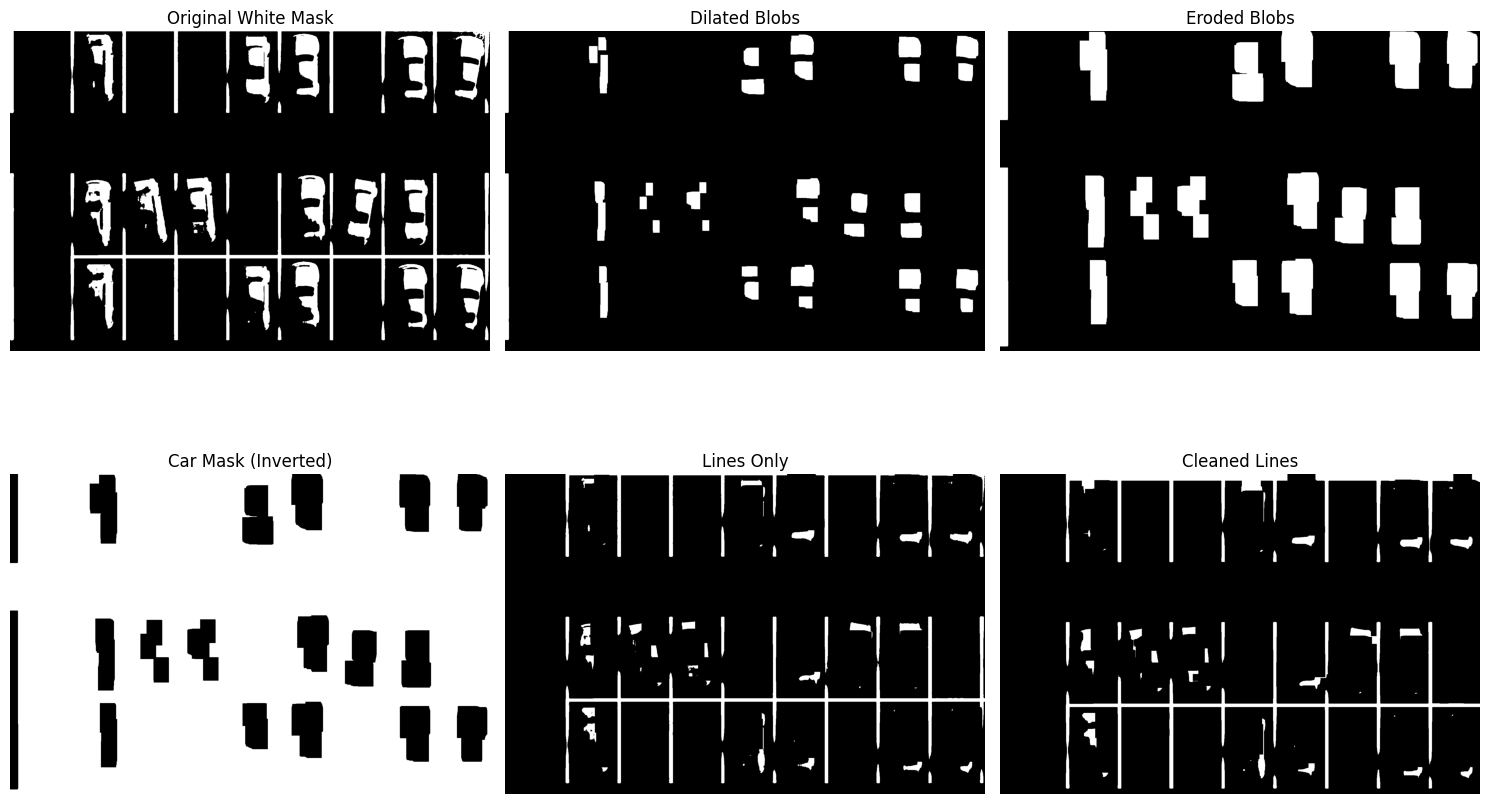

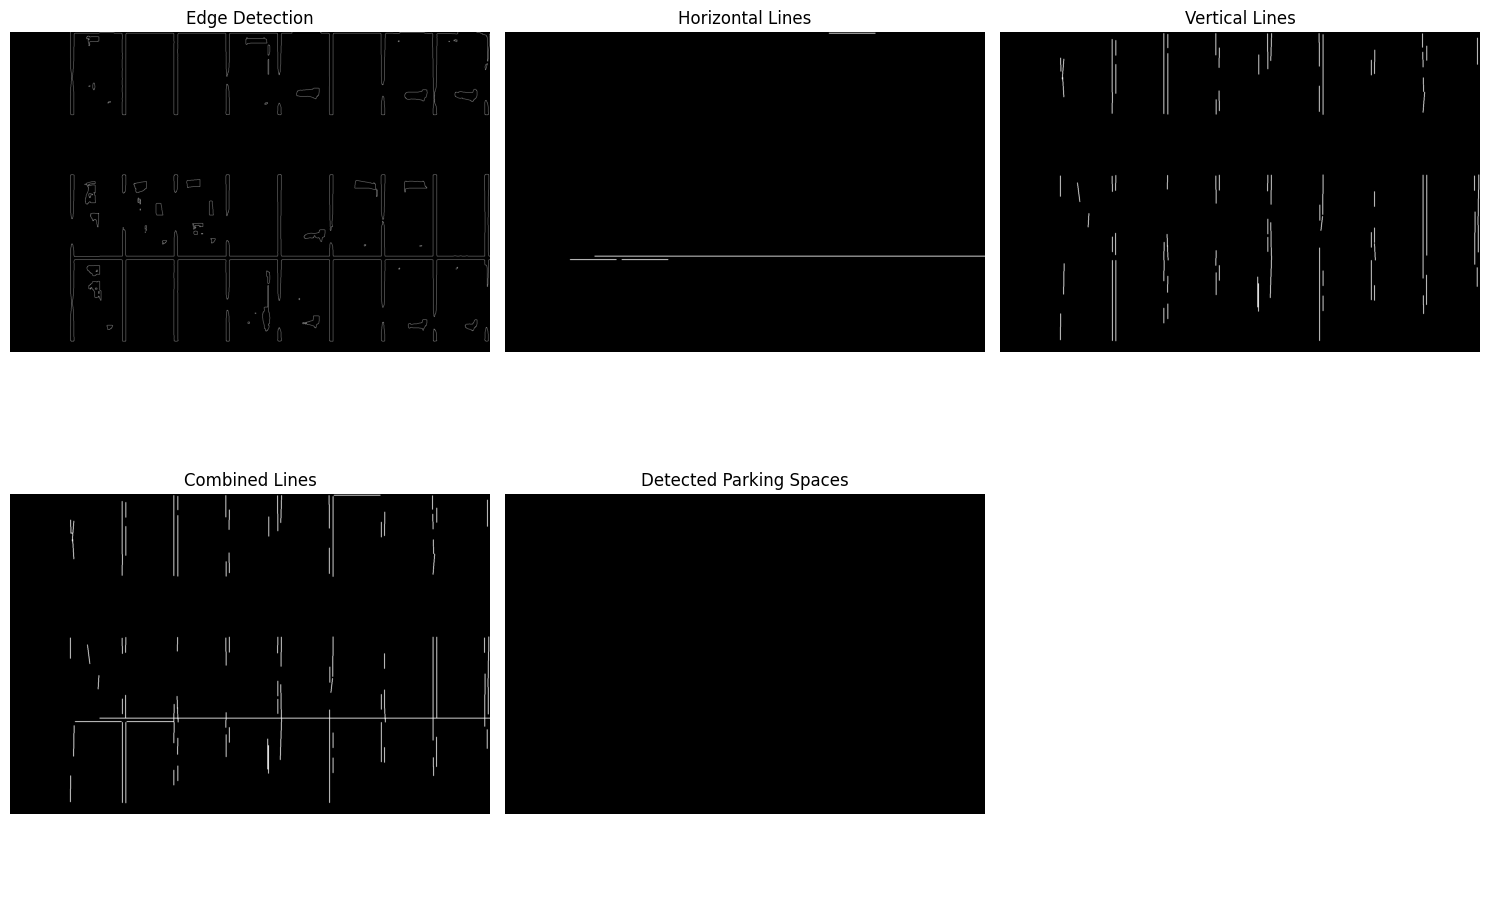

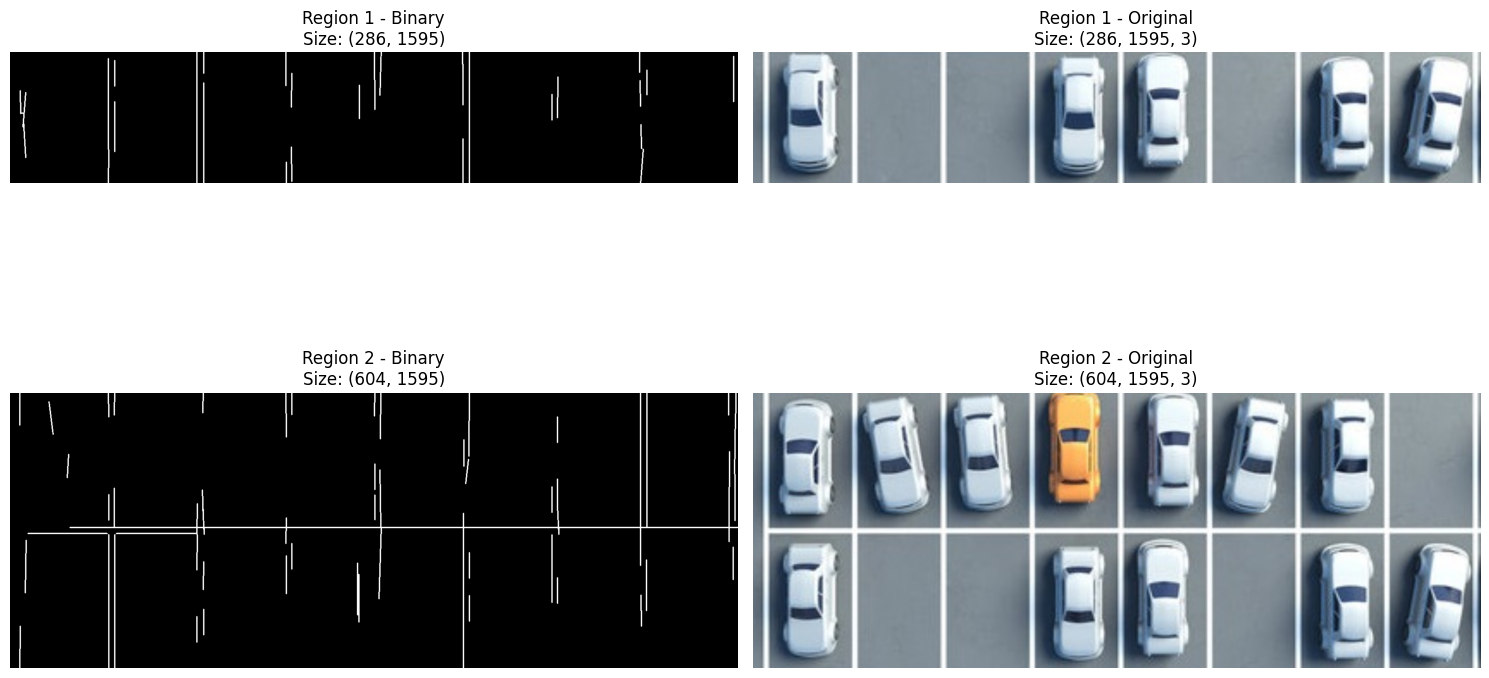

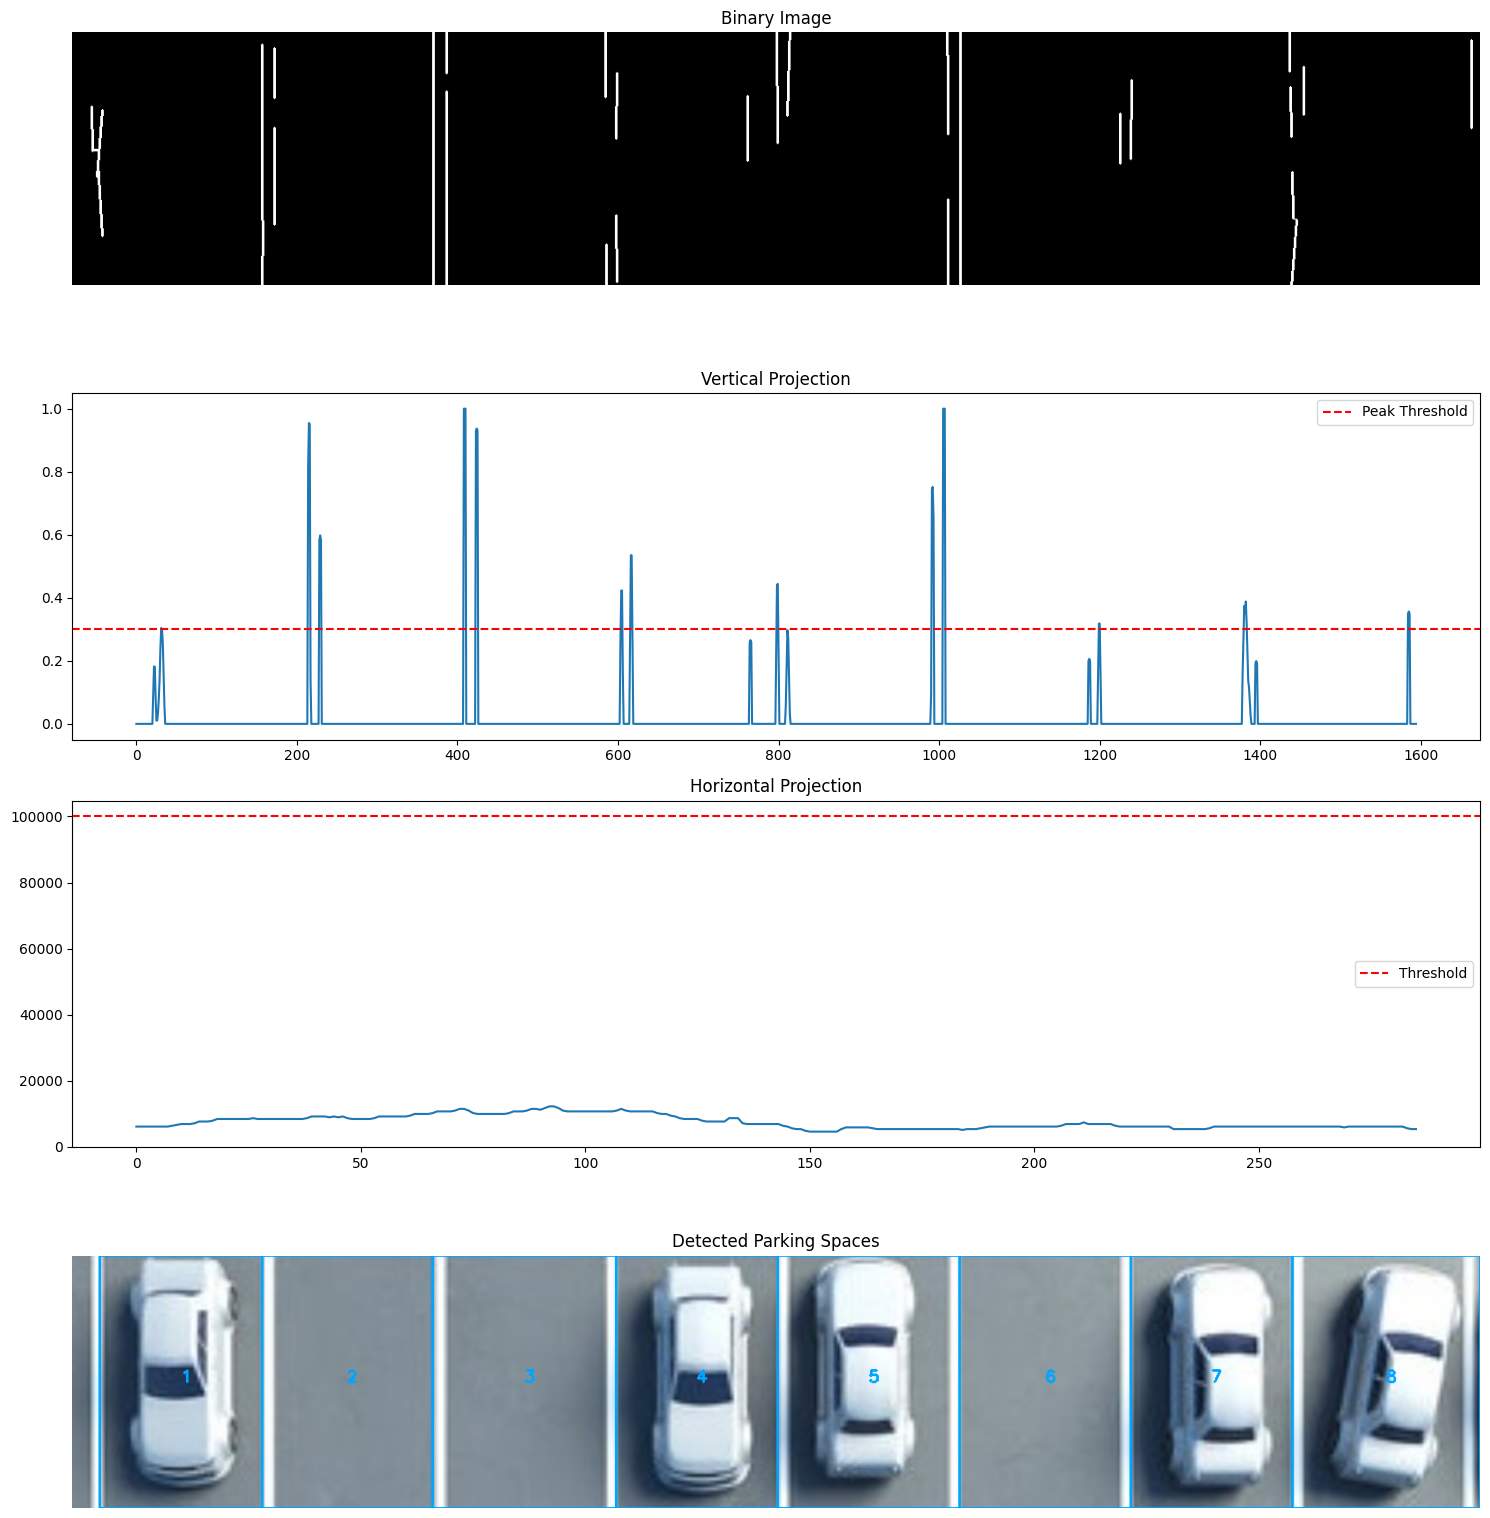

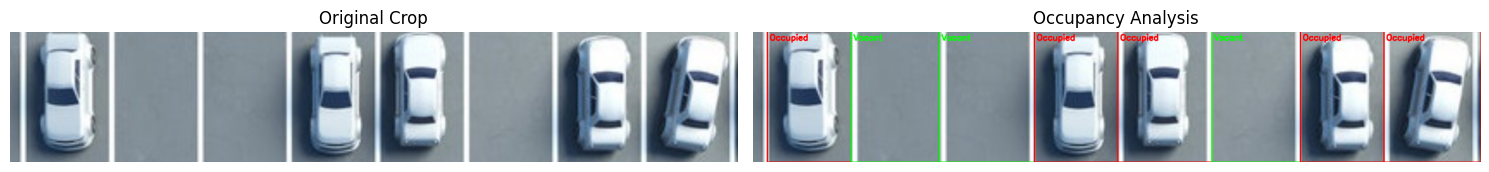

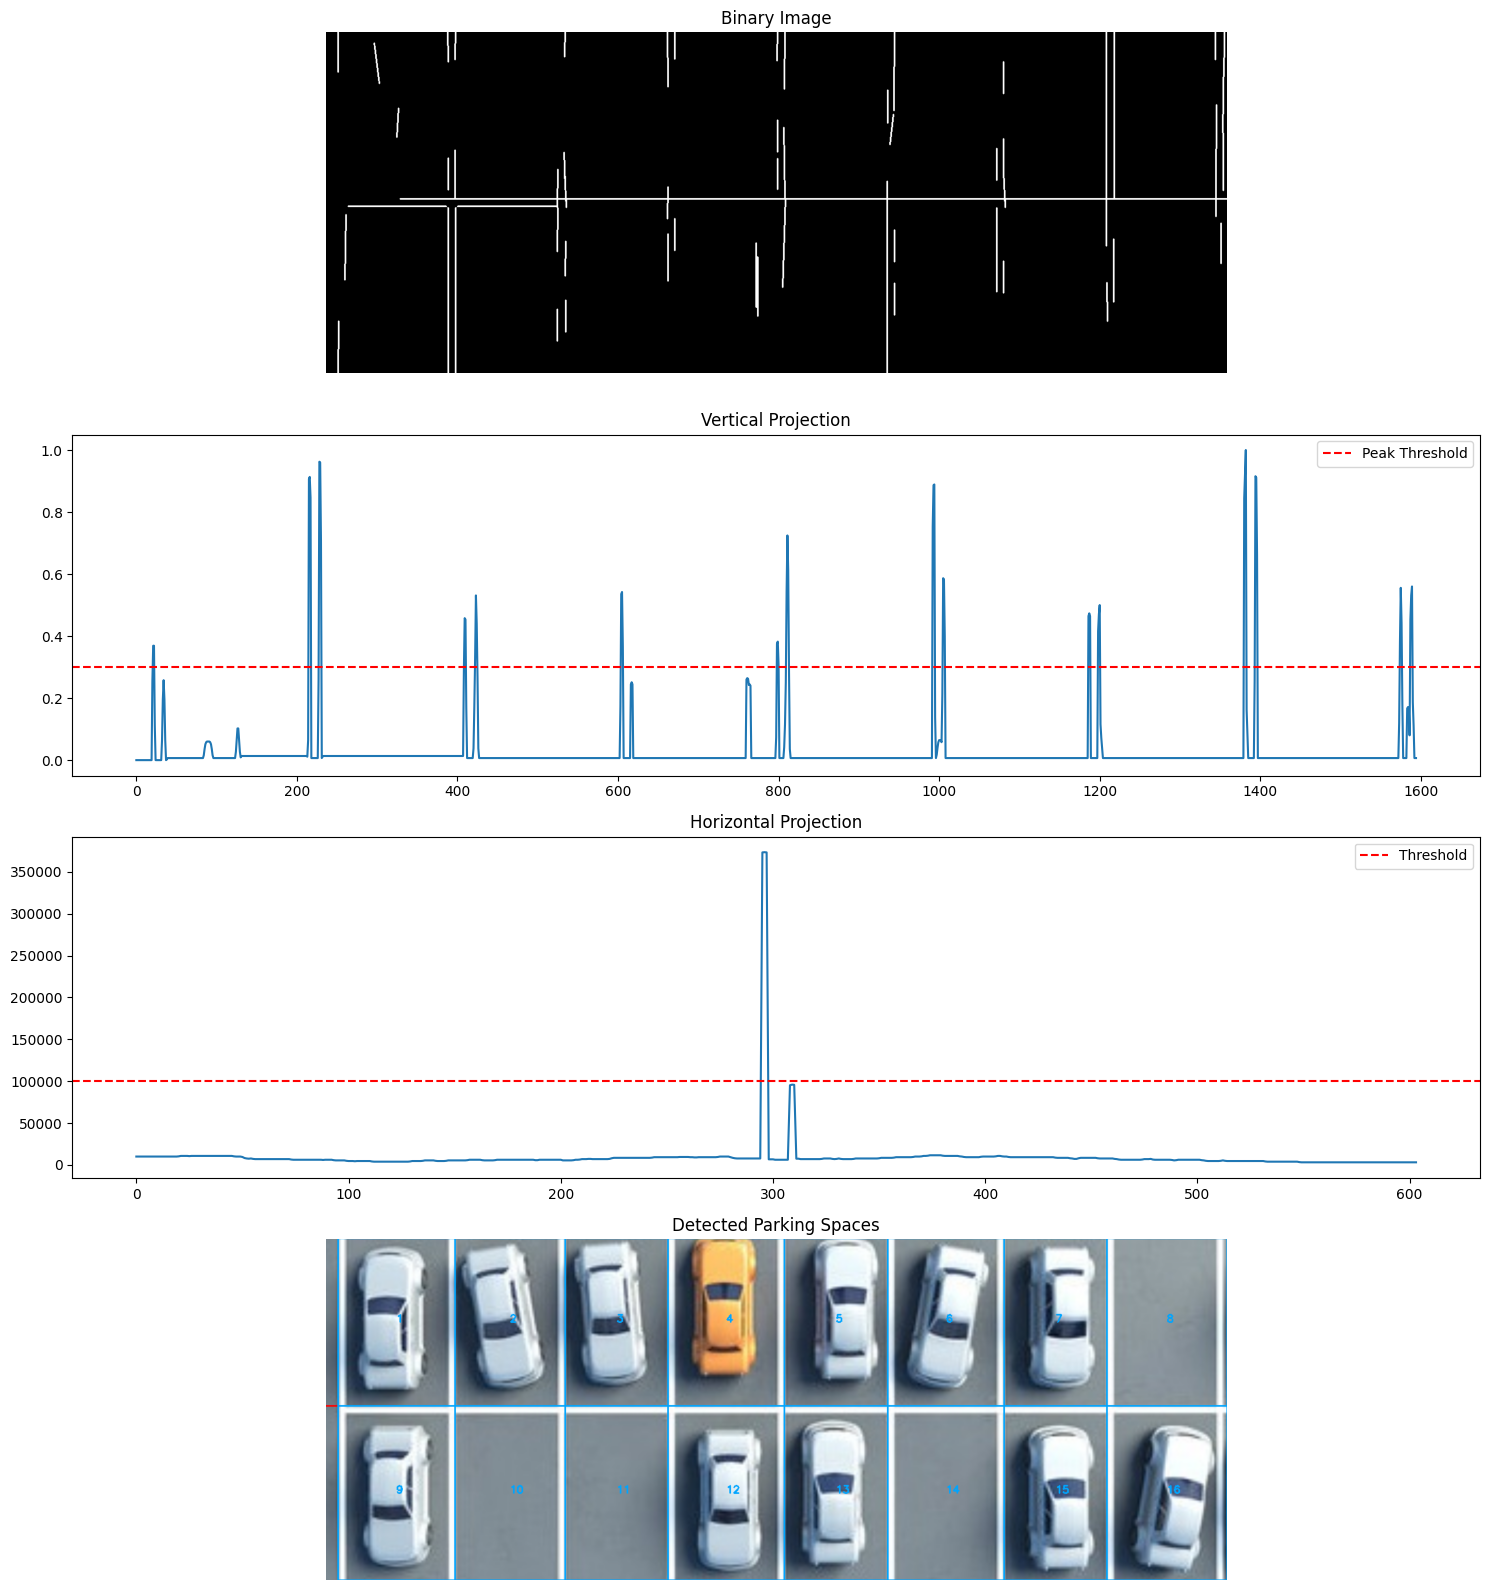

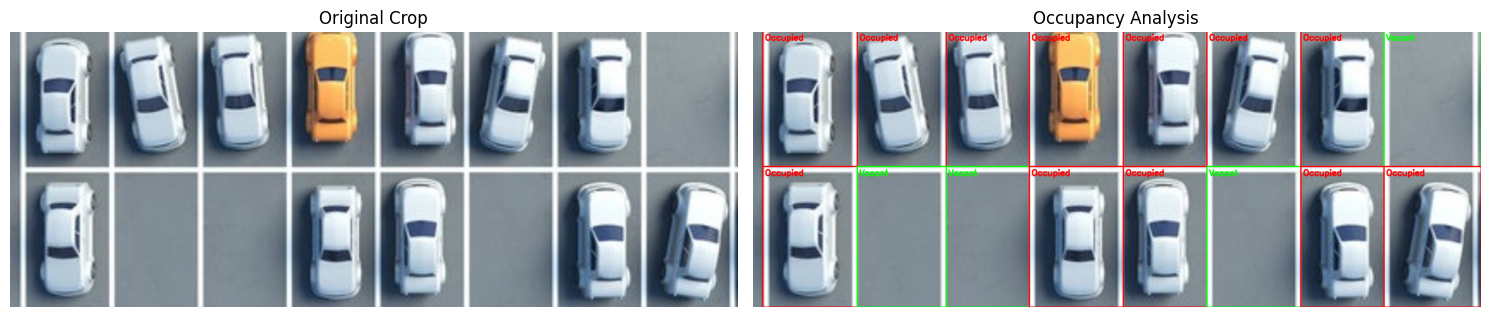

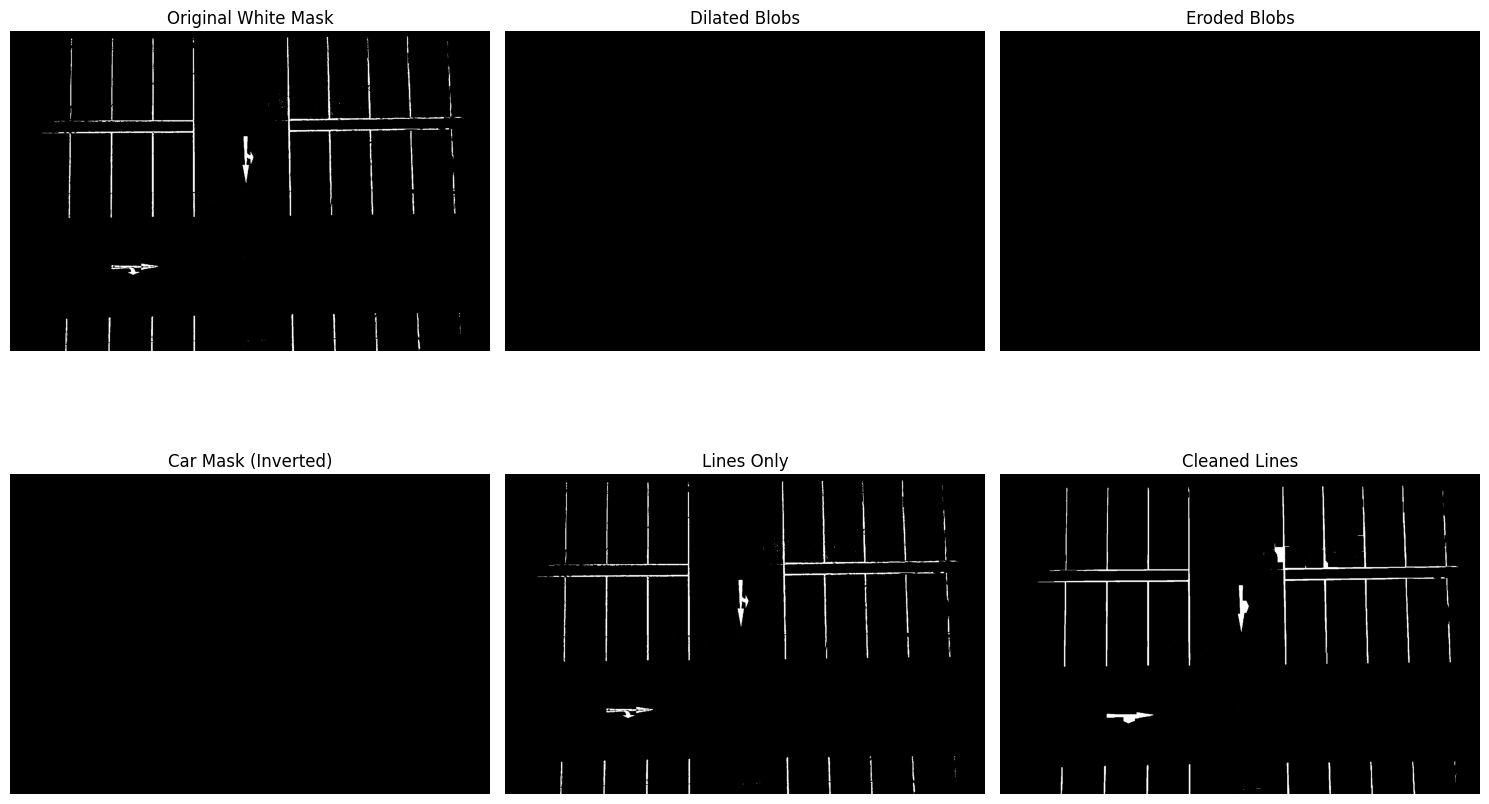

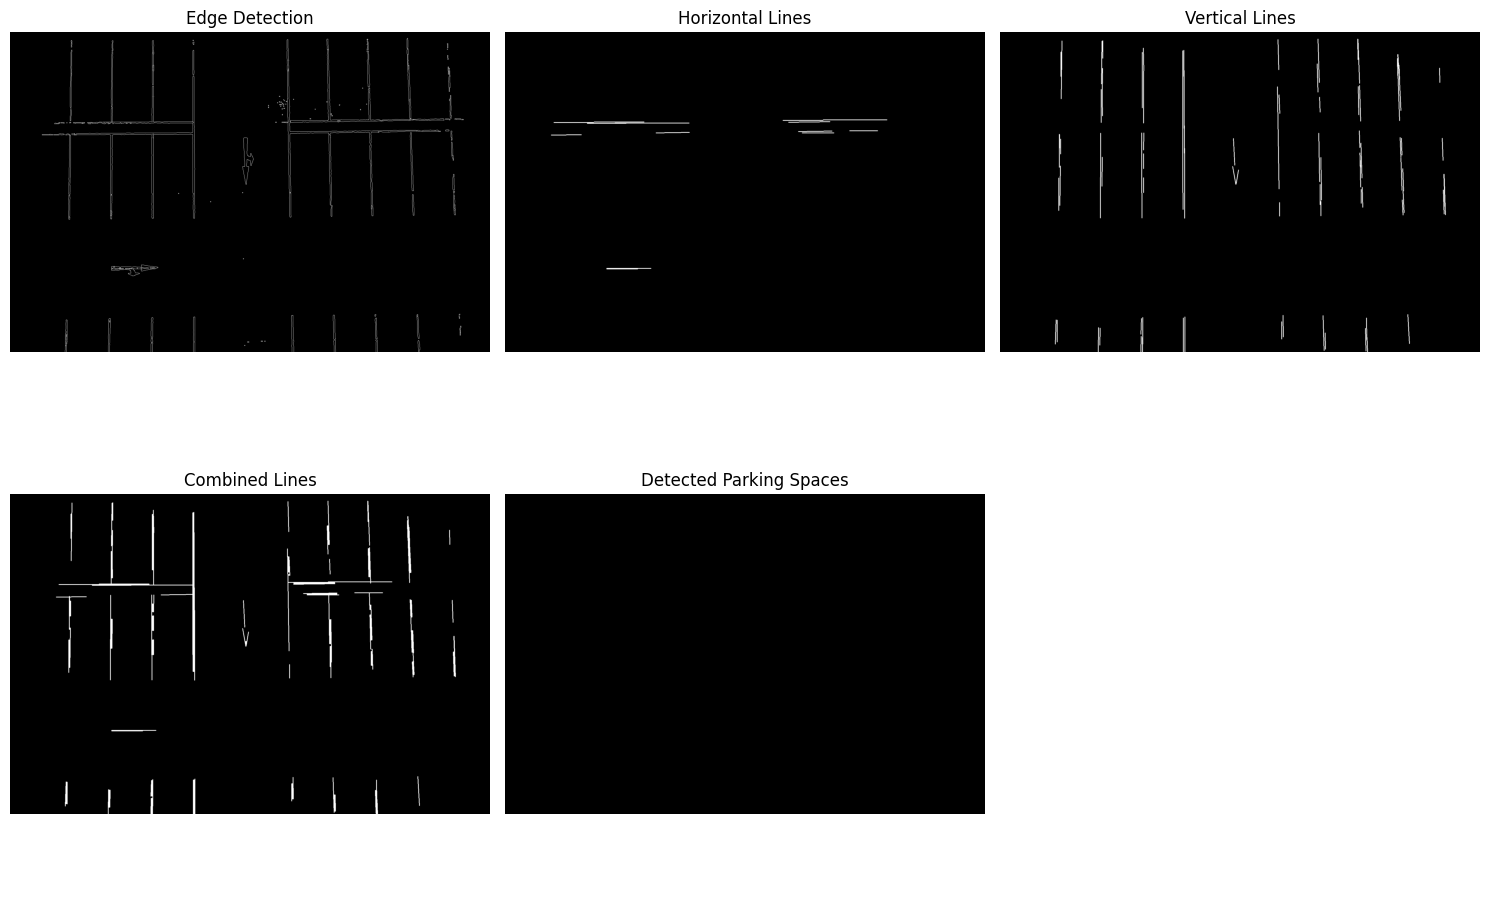

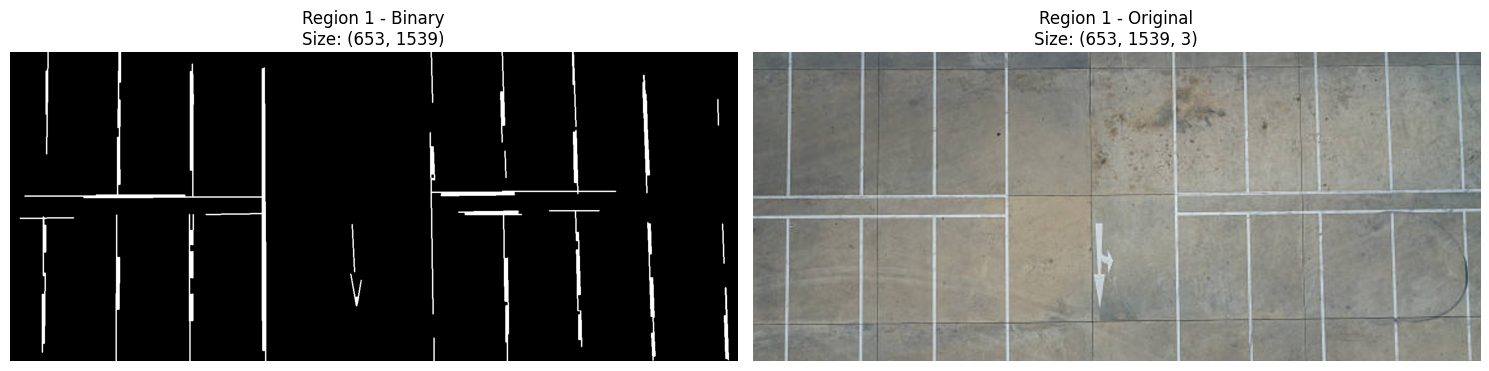

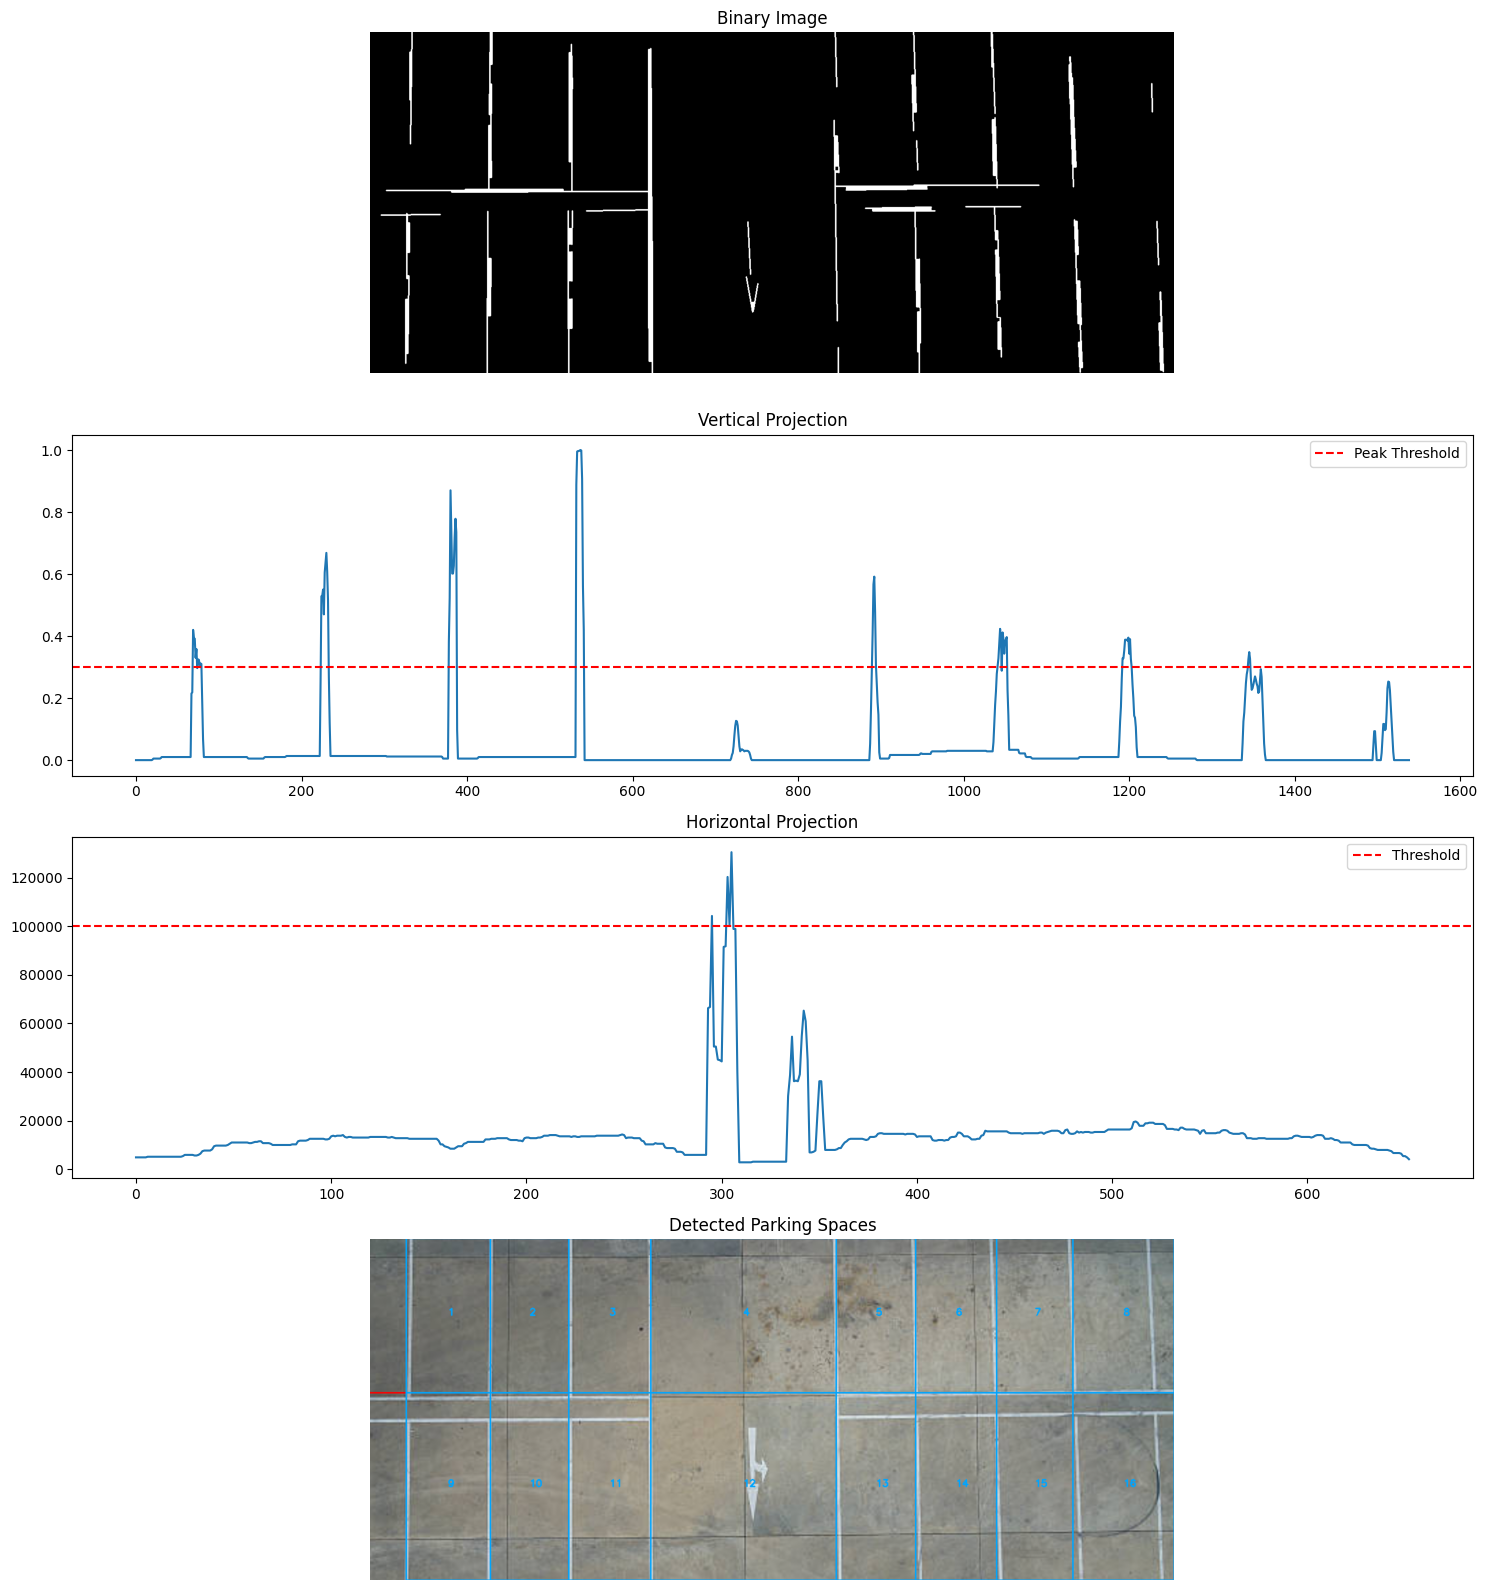

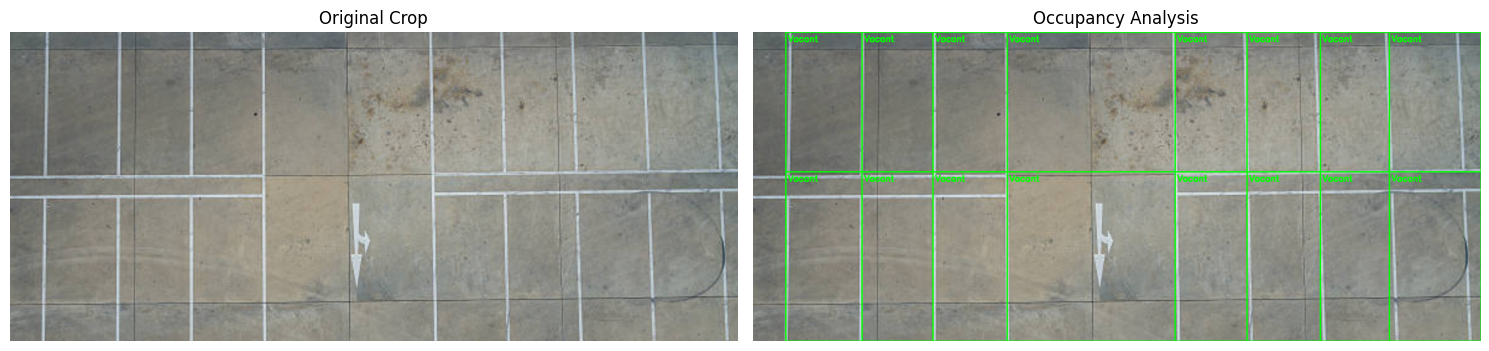

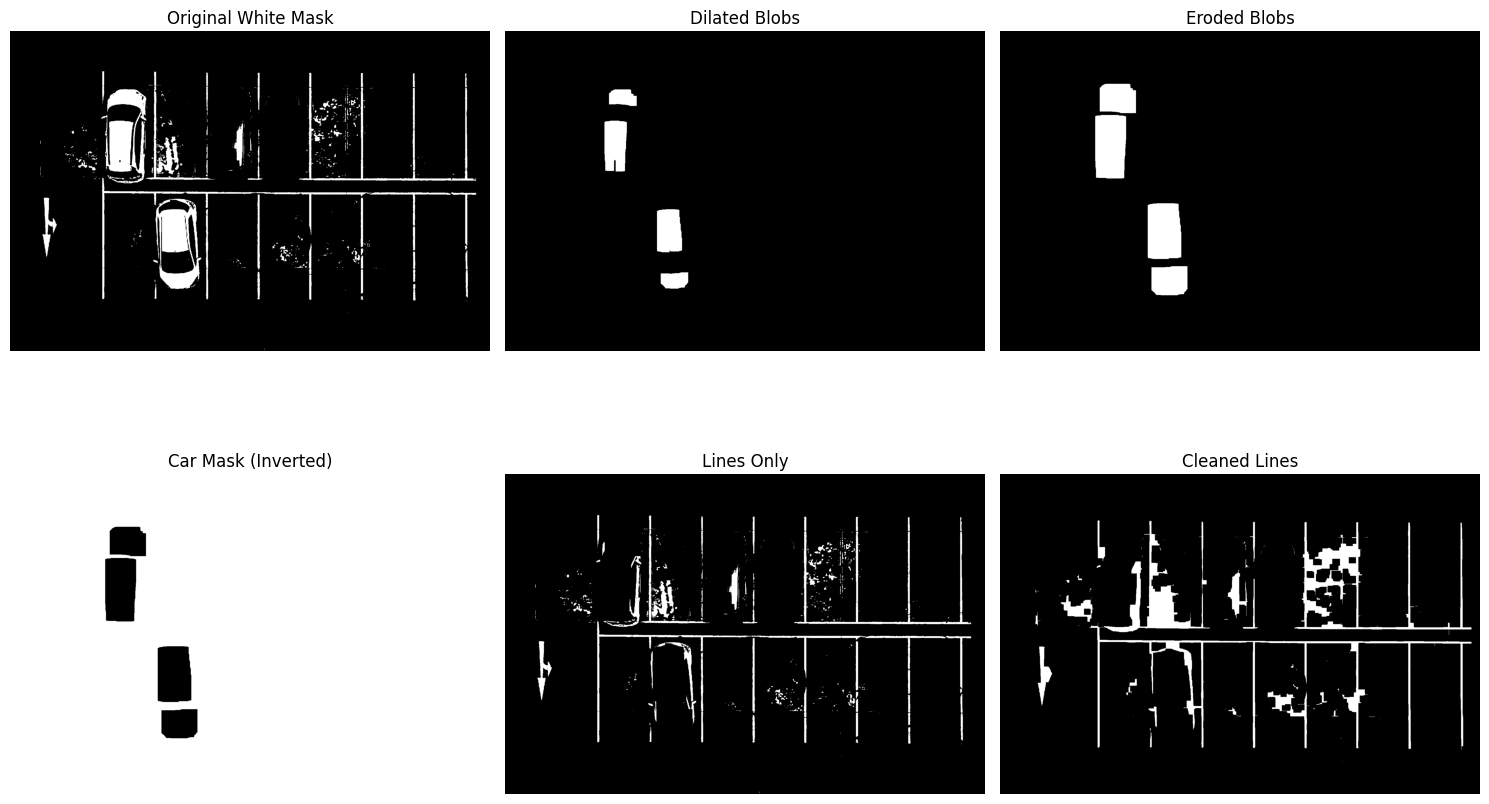

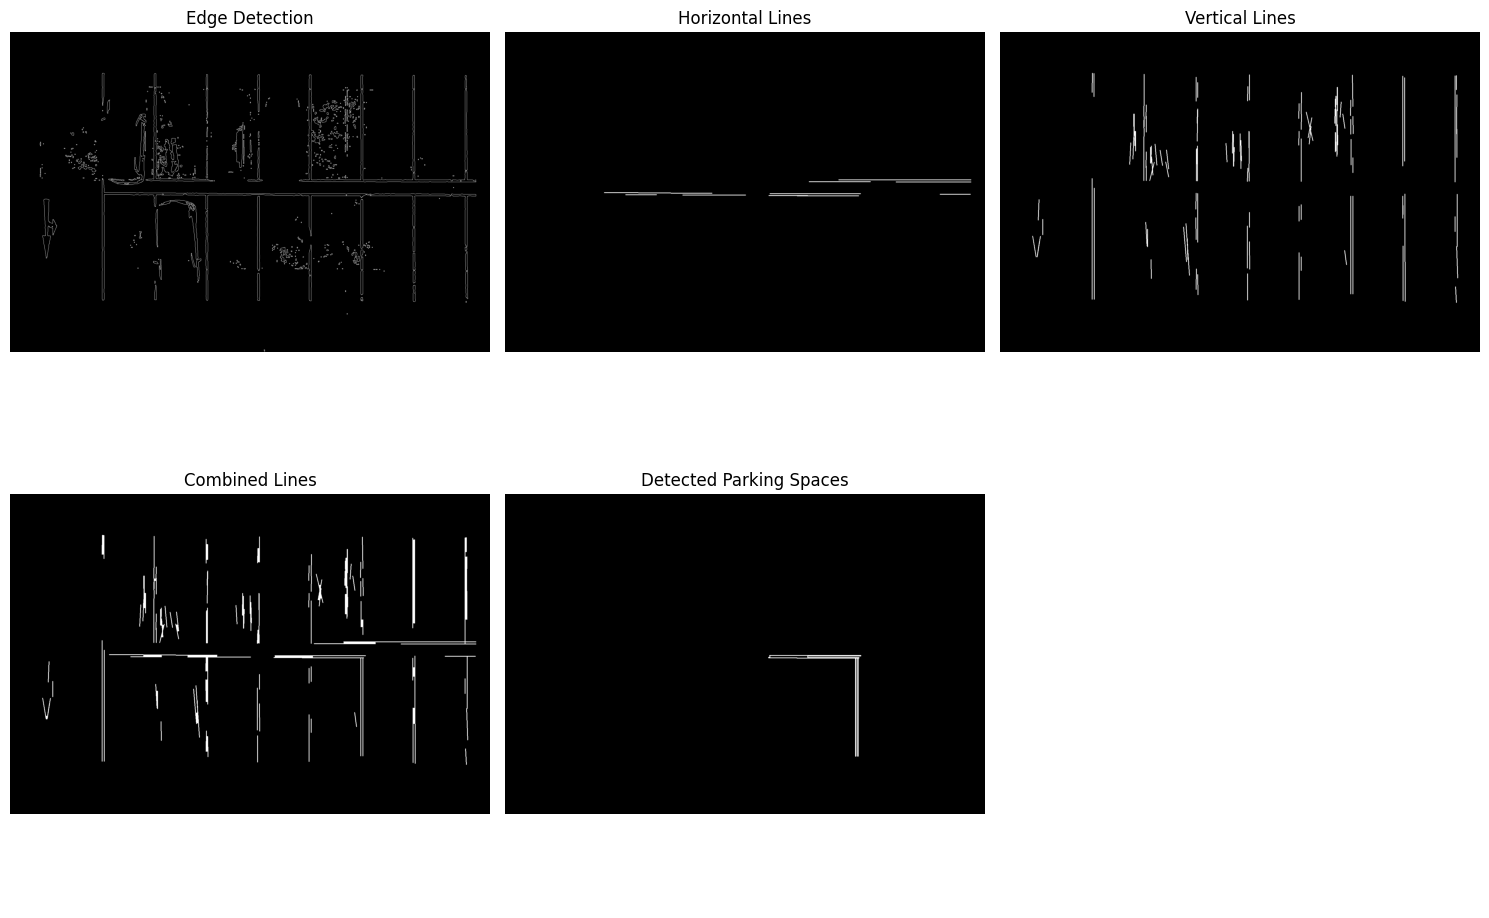

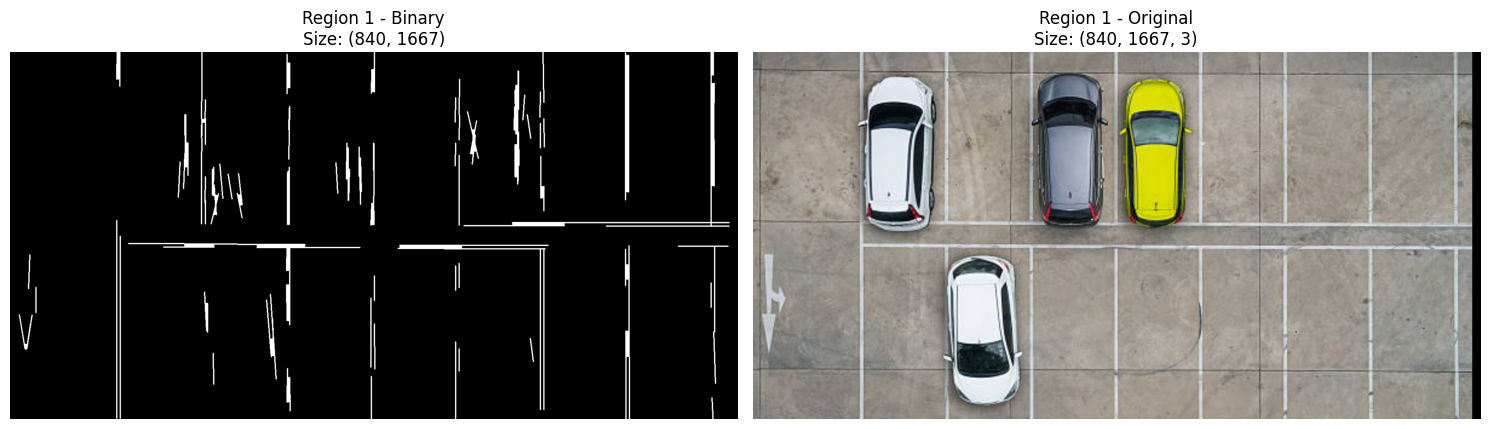

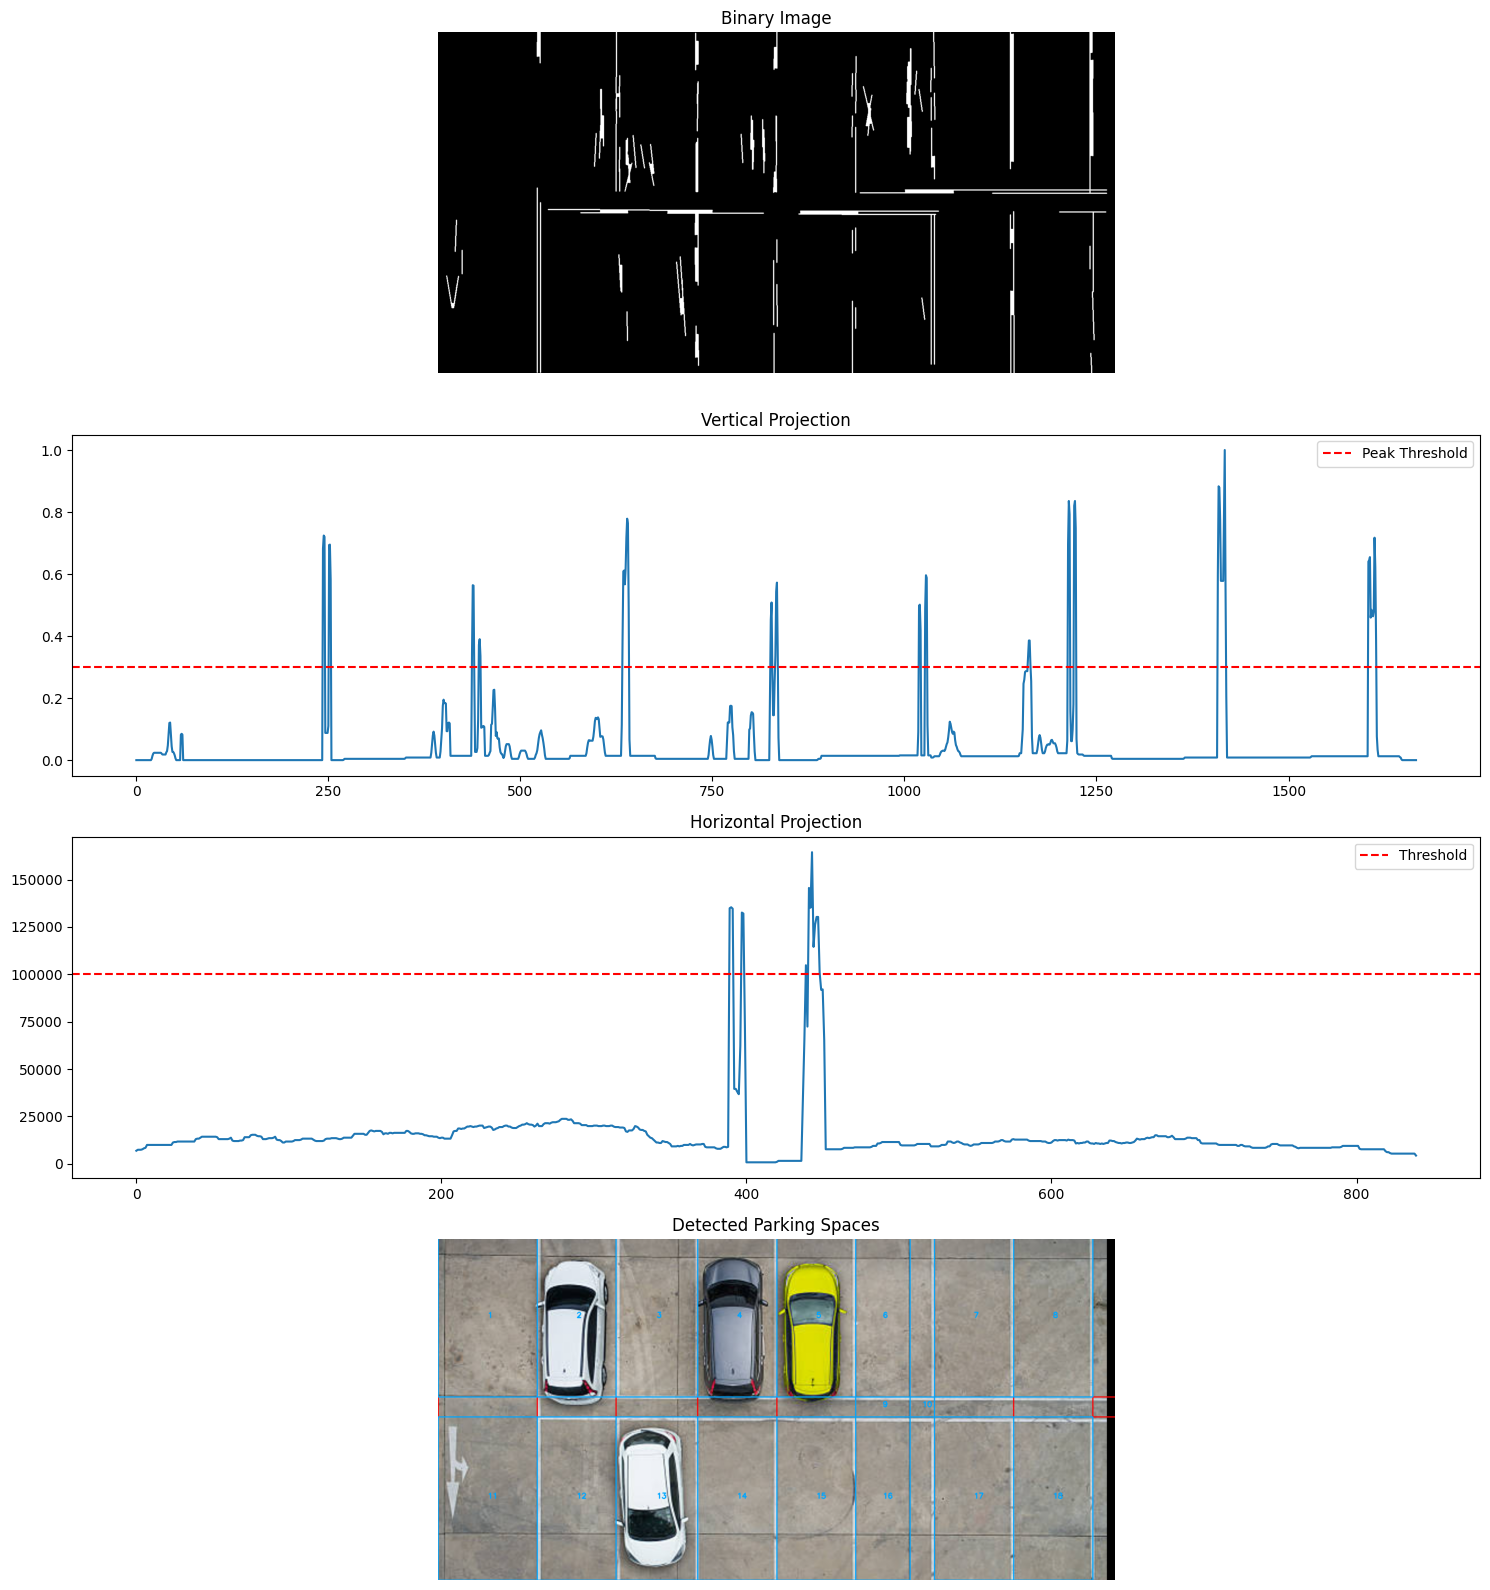

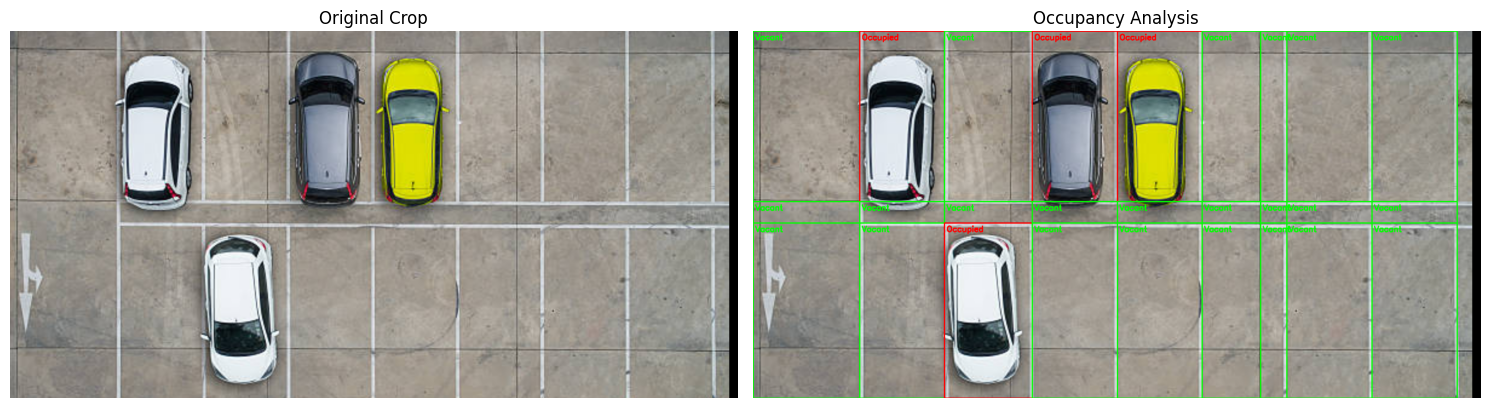

In [485]:
# Main processing loop
image_dir = 'c:/Users/Patrick/Documents/EmbeddedImageProcessing/Mini-Project/Mini_project_images/easy/*'
image_files = [file for file in glob(image_dir, recursive=True) if file.endswith(('.jpg', '.png'))]
all_results = []    

for i, file in enumerate(image_files):
    original_img = cv2.imread(file)
    standardized = standardize_image(original_img)
    parking_spaces = detect_white_lines(standardized)
    parking_lines = detect_parking_lines(parking_spaces)
    
    binary_crops, original_crops, crop_coordinates = crop_parking_regions(parking_lines, standardized)

    # if i == 1:
    #     warped_image = get_birds_eye_view(binary_crops[0])
    #     # Resize warped_image to match binary_crops[0]
    #     warped_image = cv2.resize(warped_image, 
    #                             dsize=binary_crops[0].shape[::-1], 
    #                             interpolation=cv2.INTER_LINEAR) 

    #     binary_crops[0] = warped_image 

    #     warped_original = get_birds_eye_view(original_crops[0])
    #     # Resize warped_original to match original_crops[0] 
    #     warped_original = cv2.resize(warped_original, 
    #                          dsize=(original_crops[0].shape[1], original_crops[0].shape[0]), 
    #                          interpolation=cv2.INTER_LINEAR)
    #     original_crops[0] = warped_original

    for binary_crop, original_crop in zip(binary_crops, original_crops):
        # Get the peaks from detect_parking_spaces
        v_peaks, h_peaks, _  = detect_parking_spaces(binary_crop, original_crop)
        # Use those peaks directly to extract spots
        spots = extract_parking_spots(original_crop, v_peaks, h_peaks)
        cv2.waitKey(1000)
        occupancy_results, annotated_img = analyze_parking_spot_occupancy(original_crop, spots)
        all_results.extend(occupancy_results)